In [1]:
from datasets import load_dataset

# Load the 'google/fleurs' dataset for 'hi_in' (Hindi - India)
dset = load_dataset("SEACrowd/indo_general_mt_en_id", trust_remote_code=True)


Using the latest cached version of the module from /home/fachri/.cache/huggingface/modules/datasets_modules/datasets/SEACrowd--indo_general_mt_en_id/b3c64e21ae6af5651674ae0e720323d0184a2627594ef66347616aa51e589f10 (last modified on Sat Nov  2 18:30:00 2024) since it couldn't be found locally at SEACrowd/indo_general_mt_en_id, or remotely on the Hugging Face Hub.


In [2]:
# Split the dataset into training, validation, and test sets
train_data = dset['train']
val_data = dset['validation']
test_data = dset['test']

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

import torch.nn as nn
from torch.utils.data import DataLoader
import math
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer
import random
# Randomly select 10k indices
random_indices = random.sample(range(len(train_data)), 10000)

# Select the 10k rows
train_data = train_data.select(random_indices)
# Extract source (Indonesian) and target (English) texts from each split
train_source_texts = [example['src'] for example in train_data]
train_target_texts = [example['tgt'] for example in train_data]

val_source_texts = [example['src'] for example in val_data]
val_target_texts = [example['tgt'] for example in val_data]

test_source_texts = [example['src'] for example in test_data]
test_target_texts = [example['tgt'] for example in test_data]

2024-12-02 07:17:10.405586: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 07:17:10.407145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 07:17:10.431878: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 07:17:10.432646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 07:17:10.819295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [4]:
# Add special tokens to your training data
train_target_texts = ["<SOS> " + text + " <EOS>" for text in train_target_texts]
val_target_texts = ["<SOS> " + text + " <EOS>" for text in val_target_texts]
test_target_texts = ["<SOS> " + text + " <EOS>" for text in test_target_texts]


In [5]:
train_target_texts

['<SOS> Saat ini terdapat sekitar 700 Local Government Area di Australia. <EOS>',
 '<SOS> "Ia nantinya ditangkap rezim Uni Soviet dan dieksekusi pada tanggal 13 Oktober 1937, dengan tuduhan mencoba menggubah semangat nasionalisme kemerdekaan Musavat kedalam puisi Azerbaijan. ^ Sharifov, Azad (1998)." <EOS>',
 '<SOS> Chucky kemudian menyambungkan tangannya dengan pisau dan kembali mengejar Andy. <EOS>',
 '<SOS> """Mozilla, Linux and Tor Not Accepted for Google Summer of Code 2015"". fossBytes (dalam bahasa Inggris). freenode" <EOS>',
 '<SOS> "Kenthongan (sebagian menyebut tek-tek), adalah alat musik yang terbuat dari bambu." <EOS>',
 '<SOS> NGC 8 adalah sebuah sistem bintang ganda di rasi bintang Pegasus. <EOS>',
 '<SOS> "Gereja Katolik memiliki sebuah struktur hierarkis, yang artinya sebuah urutan suci (bertolak belakang dengan struktur karismatis)." <EOS>',
 '<SOS> Espresso Vivace adalah sebuah kedai kopi dan pemanggang kopi di Seattle yang terkenal karena kopi dan cara pemanggangan k

In [6]:
# Tokenization (Source and Target)
source_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

source_tokenizer.fit_on_texts(train_source_texts)
target_tokenizer.fit_on_texts(train_target_texts)

source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# Convert texts to sequences
train_source_sequences = source_tokenizer.texts_to_sequences(train_source_texts)
train_target_sequences = target_tokenizer.texts_to_sequences(train_target_texts)

val_source_sequences = source_tokenizer.texts_to_sequences(val_source_texts)
val_target_sequences = target_tokenizer.texts_to_sequences(val_target_texts)

test_source_sequences = source_tokenizer.texts_to_sequences(test_source_texts)
test_target_sequences = target_tokenizer.texts_to_sequences(test_target_texts)

In [7]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

# Define maximum sequence lengths (modify as needed)
# max_source_length = max(len(seq) for seq in train_source_sequences)
# max_target_length = max(len(seq) for seq in train_target_sequences)
max_source_length = 100
max_target_length = 100

# Pad sequences to ensure uniform length
train_source_sequences = pad_sequences(train_source_sequences, maxlen=max_source_length, padding='post')
train_target_sequences = pad_sequences(train_target_sequences, maxlen=max_target_length, padding='post')

val_source_sequences = pad_sequences(val_source_sequences, maxlen=max_source_length, padding='post')
val_target_sequences = pad_sequences(val_target_sequences, maxlen=max_target_length, padding='post')

test_source_sequences = pad_sequences(test_source_sequences, maxlen=max_source_length, padding='post')
test_target_sequences = pad_sequences(test_target_sequences, maxlen=max_target_length, padding='post')


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, source_sequences, target_sequences):
        self.source_sequences = source_sequences
        self.target_sequences = target_sequences
    
    def __len__(self):
        return len(self.source_sequences)
    
    def __getitem__(self, idx):
        if idx >= len(self.source_sequences):
            print(f"Index {idx} out of range for source_sequences with length {len(self.source_sequences)}")
            raise IndexError("Source sequence index out of range")

        if idx >= len(self.target_sequences):
            print(f"Index {idx} out of range for target_sequences with length {len(self.target_sequences)}")
            raise IndexError("Target sequence index out of range")

        source_seq = torch.tensor(self.source_sequences[idx], dtype=torch.long)
        target_seq = torch.tensor(self.target_sequences[idx], dtype=torch.long)
        return source_seq, target_seq


assert len(train_source_sequences) == len(train_target_sequences), "Source and target sequences have different lengths!"
assert len(val_source_sequences) == len(val_target_sequences), "Source and target sequences have different lengths!"
for i, (src, tgt) in enumerate(zip(train_source_sequences, train_target_sequences)):
    if len(src) == 0 or len(tgt) == 0:
        print(f"Empty sequence found at index {i}: Source {src}, Target {tgt}")
# print(train_source_sequences[0])
# print(train_target_sequences[0])

# Create dataset and dataloader
train_dataset = SequenceDataset(train_source_sequences, train_target_sequences)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = SequenceDataset(val_source_sequences, val_target_sequences)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = SequenceDataset(test_source_sequences, test_target_sequences)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
# Example: iterate over data
for source, target in train_dataloader:
    print("Source:", source)
    print("Target:", target)


Source: tensor([[ 2007,    40,    21,  ...,     0,     0,     0],
        [  850,   106,     2,  ...,     0,     0,     0],
        [    4,   153,     6,  ...,     0,     0,     0],
        ...,
        [ 3940,   503,  2301,  ...,     0,     0,     0],
        [17024,  6947,  6948,  ...,     0,     0,     0],
        [   55, 25847,  1023,  ...,     0,     0,     0]])
Target: tensor([[   1,  235,   24,  ...,    0,    0,    0],
        [   1, 3728,   21,  ...,    0,    0,    0],
        [   1,    6,   12,  ...,    0,    0,    0],
        ...,
        [   1, 2123,  105,  ...,    0,    0,    0],
        [   1, 9182, 9183,  ...,    0,    0,    0],
        [   1, 5246,  354,  ...,    0,    0,    0]])
Source: tensor([[  595,   372,     7,  ...,     0,     0,     0],
        [   46,     1, 18388,  ...,     0,     0,     0],
        [   49,   114,     4,  ...,     0,     0,     0],
        ...,
        [   18,  9329,     2,  ...,     0,     0,     0],
        [   51,     7,     6,  ...,     0, 

In [9]:
# Scaled Dot-Product Attention
class ScaledDotProductAttention(nn.Module):
    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, V)

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linear_Q = nn.Linear(d_model, d_model)
        self.linear_K = nn.Linear(d_model, d_model)
        self.linear_V = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.attention = ScaledDotProductAttention()

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        Q = self.linear_Q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.linear_K(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.linear_V(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        attn_output = self.attention(Q, K, V, mask)
        concat = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.linear_out(concat)


In [10]:
# Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))

In [11]:
# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = self.norm1(x + attn_output)
        ff_output = self.ff(x)
        return self.norm2(x + ff_output)

In [12]:
# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.enc_dec_attention = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc_output, tgt_mask=None, memory_mask=None):
        self_attn_output = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self_attn_output)
        enc_dec_attn_output = self.enc_dec_attention(x, enc_output, enc_output, memory_mask)
        x = self.norm2(x + enc_dec_attn_output)
        ff_output = self.ff(x)
        return self.norm3(x + ff_output)

In [13]:

# Transformer Model
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len, device, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout).to(device) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout).to(device) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        seq_len_src = src.size(1)
        seq_len_tgt = tgt.size(1)
        src = self.encoder_embedding(src) + self.positional_encoding[:, :seq_len_src, :]
        tgt = self.decoder_embedding(tgt) + self.positional_encoding[:, :seq_len_tgt, :]

        for layer in self.encoder_layers:
            src = layer(src, src_mask)

        for layer in self.decoder_layers:
            tgt = layer(tgt, src, tgt_mask)

        return self.output_layer(tgt)

In [14]:
# Model Hyperparameters
vocab_size = max(source_vocab_size, target_vocab_size)
d_model = 512
num_heads = 8
d_ff = 2048
num_layers = 6
max_seq_len = 512
dropout = 0.1
learning_rate = 5e-5
num_epochs = 40

# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len, device, dropout)
# device = "cuda"
model.to(device)

# Optimizer and Loss Function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()



In [15]:
for i, seq in enumerate(train_source_sequences):
    if max(seq) >= vocab_size:
        print(f"Out-of-range index found in source sequence {i}: {seq}")
for i, seq in enumerate(train_target_sequences):
    if max(seq) >= vocab_size:
        print(f"Out-of-range index found in target sequence {i}: {seq}")


In [16]:
import time
import torch
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu
import os
import csv
# File paths
checkpoint_path = "model_checkpoint.pth"
loss_csv_path = "training_results.csv"
# Function to save checkpoint
def save_checkpoint(model, optimizer, epoch, loss_history, val_loss_history, best_bleu_score=None):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss_history": loss_history,
        "val_loss_history": val_loss_history,
        "best_bleu_score": best_bleu_score,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}.")

# Function to load checkpoint
def load_checkpoint(model, optimizer):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        loss_history = checkpoint["loss_history"]
        val_loss_history = checkpoint["val_loss_history"]
        best_bleu_score = checkpoint.get("best_bleu_score", None)
        print(f"Resumed training from epoch {start_epoch}.")
        return start_epoch, loss_history, val_loss_history, best_bleu_score
    else:
        print("No checkpoint found. Starting fresh training.")
        return 0, [], [], None

# Function to save losses to CSV
def save_losses_to_csv(loss_history, val_loss_history):
    data = {"Epoch": list(range(1, len(loss_history) + 1)), 
            "Train Loss": loss_history, 
            "Val Loss": val_loss_history}
    df = pd.DataFrame(data)
    df.to_csv(loss_csv_path, index=False)
    print(f"Losses saved to {loss_csv_path}.")
# Function to save a single epoch's losses to the CSV
def append_loss_to_csv(epoch, train_loss, val_loss, bleu_score,time_taken, csv_path="training_transformer_results.csv"):
    file_exists = os.path.exists(csv_path)
    with open(csv_path, mode="a", newline="") as file:
        writer = csv.writer(file)
        if not file_exists:
            # Write header if the file is being created for the first time
            writer.writerow(["Epoch", "Train Loss", "Val Loss", "Bleu Score", "Time Taken"])
        # Append the new epoch's losses
        writer.writerow([epoch, train_loss, val_loss, bleu_score, time_taken])
    print(f"Epoch {epoch + 1}:Val Loss: {val_loss:.4f} - Saved to {csv_path}.")

# Training loop
start_epoch, loss_history, val_loss_history, best_bleu_score = load_checkpoint(model, optimizer)

# List to store loss and BLEU scores
loss_history = []
val_loss_history = []
bleu_scores = []

# Initialize variables for checkpointing
best_bleu_score = 0.0
best_model_path = "best_model.pth"

# Function to calculate BLEU score
def calculate_bleu(references, hypotheses):
    """
    Compute BLEU scores for a batch of references and hypotheses.
    `references`: List of lists of reference sentences (tokenized).
    `hypotheses`: List of hypothesis sentences (tokenized).
    """
    scores = []
    for ref, hyp in zip(references, hypotheses):
        # BLEU score for each sentence
        scores.append(sentence_bleu([ref], hyp))
    return sum(scores) / len(scores)  # Average BLEU score for the batch

for epoch in range(start_epoch, num_epochs):
    start = time.time()
    # Training
    model.train()
    total_train_loss = 0
    for src, tgt in tqdm(train_dataloader):
        src = src.to(device)
        tgt = tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        outputs = model(src, tgt_input)  # Model output (logits)
        loss = criterion(outputs.view(-1, vocab_size), tgt_output.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    references = []  # Store reference sentences for BLEU calculation
    hypotheses = []  # Store hypothesis sentences for BLEU calculation
    with torch.no_grad():
        for src, tgt in val_dataloader:
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            outputs = model(src, tgt_input)  # Shape: (batch_size, seq_len, vocab_size)
            loss = criterion(outputs.view(-1, vocab_size), tgt_output.contiguous().view(-1))
            total_val_loss += loss.item()

            # Collect predictions and references for BLEU
            predictions = outputs.argmax(dim=-1)  # Convert logits to token predictions
            references.extend(tgt_output.cpu().tolist())
            hypotheses.extend(predictions.cpu().tolist())

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)

    # Calculate BLEU score
    bleu_score = calculate_bleu(references, hypotheses)
    bleu_scores.append(bleu_score)

    # Checkpointing
    if bleu_score > best_bleu_score:
        best_bleu_score = bleu_score
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with BLEU score: {best_bleu_score:.4f}")

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, BLEU Score: {bleu_score:.4f}")
    # Save checkpoint
    save_checkpoint(model, optimizer, epoch, loss_history, val_loss_history)
    time_taken = time.time() - start
    # Save current epoch losses to CSV
    append_loss_to_csv(epoch, avg_train_loss, avg_val_loss, bleu_score, time_taken)

No checkpoint found. Starting fresh training.


100%|██████████| 313/313 [01:14<00:00,  4.21it/s]
/home/fachri/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/fachri/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/fachri/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Cons

New best model saved with BLEU score: 0.8356
Epoch 1/40, Train Loss: 1.7180, Val Loss: 1.3054, BLEU Score: 0.8356
Checkpoint saved at epoch 0.
Epoch 1:Val Loss: 1.3054 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.21it/s]


New best model saved with BLEU score: 0.8363
Epoch 2/40, Train Loss: 1.4896, Val Loss: 1.2470, BLEU Score: 0.8363
Checkpoint saved at epoch 1.
Epoch 2:Val Loss: 1.2470 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


New best model saved with BLEU score: 0.8398
Epoch 3/40, Train Loss: 1.4161, Val Loss: 1.2022, BLEU Score: 0.8398
Checkpoint saved at epoch 2.
Epoch 3:Val Loss: 1.2022 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


New best model saved with BLEU score: 0.8406
Epoch 4/40, Train Loss: 1.3527, Val Loss: 1.1650, BLEU Score: 0.8406
Checkpoint saved at epoch 3.
Epoch 4:Val Loss: 1.1650 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.17it/s]


New best model saved with BLEU score: 0.8419
Epoch 5/40, Train Loss: 1.2934, Val Loss: 1.1300, BLEU Score: 0.8419
Checkpoint saved at epoch 4.
Epoch 5:Val Loss: 1.1300 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


New best model saved with BLEU score: 0.8436
Epoch 6/40, Train Loss: 1.2353, Val Loss: 1.1095, BLEU Score: 0.8436
Checkpoint saved at epoch 5.
Epoch 6:Val Loss: 1.1095 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


New best model saved with BLEU score: 0.8445
Epoch 7/40, Train Loss: 1.1776, Val Loss: 1.0728, BLEU Score: 0.8445
Checkpoint saved at epoch 6.
Epoch 7:Val Loss: 1.0728 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


New best model saved with BLEU score: 0.8461
Epoch 8/40, Train Loss: 1.1183, Val Loss: 1.0452, BLEU Score: 0.8461
Checkpoint saved at epoch 7.
Epoch 8:Val Loss: 1.0452 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


New best model saved with BLEU score: 0.8475
Epoch 9/40, Train Loss: 1.0571, Val Loss: 1.0224, BLEU Score: 0.8475
Checkpoint saved at epoch 8.
Epoch 9:Val Loss: 1.0224 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


New best model saved with BLEU score: 0.8499
Epoch 10/40, Train Loss: 0.9944, Val Loss: 1.0035, BLEU Score: 0.8499
Checkpoint saved at epoch 9.
Epoch 10:Val Loss: 1.0035 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


New best model saved with BLEU score: 0.8506
Epoch 11/40, Train Loss: 0.9298, Val Loss: 0.9777, BLEU Score: 0.8506
Checkpoint saved at epoch 10.
Epoch 11:Val Loss: 0.9777 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.17it/s]


New best model saved with BLEU score: 0.8524
Epoch 12/40, Train Loss: 0.8635, Val Loss: 0.9584, BLEU Score: 0.8524
Checkpoint saved at epoch 11.
Epoch 12:Val Loss: 0.9584 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


New best model saved with BLEU score: 0.8534
Epoch 13/40, Train Loss: 0.7979, Val Loss: 0.9430, BLEU Score: 0.8534
Checkpoint saved at epoch 12.
Epoch 13:Val Loss: 0.9430 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


New best model saved with BLEU score: 0.8538
Epoch 14/40, Train Loss: 0.7331, Val Loss: 0.9308, BLEU Score: 0.8538
Checkpoint saved at epoch 13.
Epoch 14:Val Loss: 0.9308 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


New best model saved with BLEU score: 0.8552
Epoch 15/40, Train Loss: 0.6682, Val Loss: 0.9222, BLEU Score: 0.8552
Checkpoint saved at epoch 14.
Epoch 15:Val Loss: 0.9222 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


New best model saved with BLEU score: 0.8554
Epoch 16/40, Train Loss: 0.6065, Val Loss: 0.9144, BLEU Score: 0.8554
Checkpoint saved at epoch 15.
Epoch 16:Val Loss: 0.9144 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


New best model saved with BLEU score: 0.8570
Epoch 17/40, Train Loss: 0.5470, Val Loss: 0.9236, BLEU Score: 0.8570
Checkpoint saved at epoch 16.
Epoch 17:Val Loss: 0.9236 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


New best model saved with BLEU score: 0.8579
Epoch 18/40, Train Loss: 0.4901, Val Loss: 0.9096, BLEU Score: 0.8579
Checkpoint saved at epoch 17.
Epoch 18:Val Loss: 0.9096 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


New best model saved with BLEU score: 0.8581
Epoch 19/40, Train Loss: 0.4339, Val Loss: 0.9023, BLEU Score: 0.8581
Checkpoint saved at epoch 18.
Epoch 19:Val Loss: 0.9023 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.22it/s]


New best model saved with BLEU score: 0.8590
Epoch 20/40, Train Loss: 0.3816, Val Loss: 0.9014, BLEU Score: 0.8590
Checkpoint saved at epoch 19.
Epoch 20:Val Loss: 0.9014 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.22it/s]


Epoch 21/40, Train Loss: 0.3329, Val Loss: 0.8927, BLEU Score: 0.8586
Checkpoint saved at epoch 20.
Epoch 21:Val Loss: 0.8927 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


New best model saved with BLEU score: 0.8597
Epoch 22/40, Train Loss: 0.2868, Val Loss: 0.9005, BLEU Score: 0.8597
Checkpoint saved at epoch 21.
Epoch 22:Val Loss: 0.9005 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.21it/s]


New best model saved with BLEU score: 0.8599
Epoch 23/40, Train Loss: 0.2441, Val Loss: 0.8911, BLEU Score: 0.8599
Checkpoint saved at epoch 22.
Epoch 23:Val Loss: 0.8911 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


New best model saved with BLEU score: 0.8606
Epoch 24/40, Train Loss: 0.2048, Val Loss: 0.8961, BLEU Score: 0.8606
Checkpoint saved at epoch 23.
Epoch 24:Val Loss: 0.8961 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


Epoch 25/40, Train Loss: 0.1697, Val Loss: 0.8919, BLEU Score: 0.8606
Checkpoint saved at epoch 24.
Epoch 25:Val Loss: 0.8919 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


New best model saved with BLEU score: 0.8611
Epoch 26/40, Train Loss: 0.1393, Val Loss: 0.9052, BLEU Score: 0.8611
Checkpoint saved at epoch 25.
Epoch 26:Val Loss: 0.9052 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.21it/s]


New best model saved with BLEU score: 0.8612
Epoch 27/40, Train Loss: 0.1136, Val Loss: 0.8921, BLEU Score: 0.8612
Checkpoint saved at epoch 26.
Epoch 27:Val Loss: 0.8921 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


New best model saved with BLEU score: 0.8619
Epoch 28/40, Train Loss: 0.0923, Val Loss: 0.9013, BLEU Score: 0.8619
Checkpoint saved at epoch 27.
Epoch 28:Val Loss: 0.9013 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


Epoch 29/40, Train Loss: 0.0757, Val Loss: 0.8935, BLEU Score: 0.8616
Checkpoint saved at epoch 28.
Epoch 29:Val Loss: 0.8935 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


New best model saved with BLEU score: 0.8621
Epoch 30/40, Train Loss: 0.0627, Val Loss: 0.8942, BLEU Score: 0.8621
Checkpoint saved at epoch 29.
Epoch 30:Val Loss: 0.8942 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


New best model saved with BLEU score: 0.8624
Epoch 31/40, Train Loss: 0.0533, Val Loss: 0.9035, BLEU Score: 0.8624
Checkpoint saved at epoch 30.
Epoch 31:Val Loss: 0.9035 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


New best model saved with BLEU score: 0.8629
Epoch 32/40, Train Loss: 0.0462, Val Loss: 0.8873, BLEU Score: 0.8629
Checkpoint saved at epoch 31.
Epoch 32:Val Loss: 0.8873 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


Epoch 33/40, Train Loss: 0.0418, Val Loss: 0.8955, BLEU Score: 0.8626
Checkpoint saved at epoch 32.
Epoch 33:Val Loss: 0.8955 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


New best model saved with BLEU score: 0.8631
Epoch 34/40, Train Loss: 0.0383, Val Loss: 0.8899, BLEU Score: 0.8631
Checkpoint saved at epoch 33.
Epoch 34:Val Loss: 0.8899 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:14<00:00,  4.17it/s]


New best model saved with BLEU score: 0.8634
Epoch 35/40, Train Loss: 0.0344, Val Loss: 0.8940, BLEU Score: 0.8634
Checkpoint saved at epoch 34.
Epoch 35:Val Loss: 0.8940 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


New best model saved with BLEU score: 0.8637
Epoch 36/40, Train Loss: 0.0321, Val Loss: 0.9011, BLEU Score: 0.8637
Checkpoint saved at epoch 35.
Epoch 36:Val Loss: 0.9011 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:15<00:00,  4.16it/s]


Epoch 37/40, Train Loss: 0.0297, Val Loss: 0.8900, BLEU Score: 0.8637
Checkpoint saved at epoch 36.
Epoch 37:Val Loss: 0.8900 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


New best model saved with BLEU score: 0.8642
Epoch 38/40, Train Loss: 0.0279, Val Loss: 0.8916, BLEU Score: 0.8642
Checkpoint saved at epoch 37.
Epoch 38:Val Loss: 0.8916 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:15<00:00,  4.16it/s]


New best model saved with BLEU score: 0.8646
Epoch 39/40, Train Loss: 0.0265, Val Loss: 0.8959, BLEU Score: 0.8646
Checkpoint saved at epoch 38.
Epoch 39:Val Loss: 0.8959 - Saved to training_transformer_results.csv.


100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


New best model saved with BLEU score: 0.8646
Epoch 40/40, Train Loss: 0.0255, Val Loss: 0.9026, BLEU Score: 0.8646
Checkpoint saved at epoch 39.
Epoch 40:Val Loss: 0.9026 - Saved to training_transformer_results.csv.


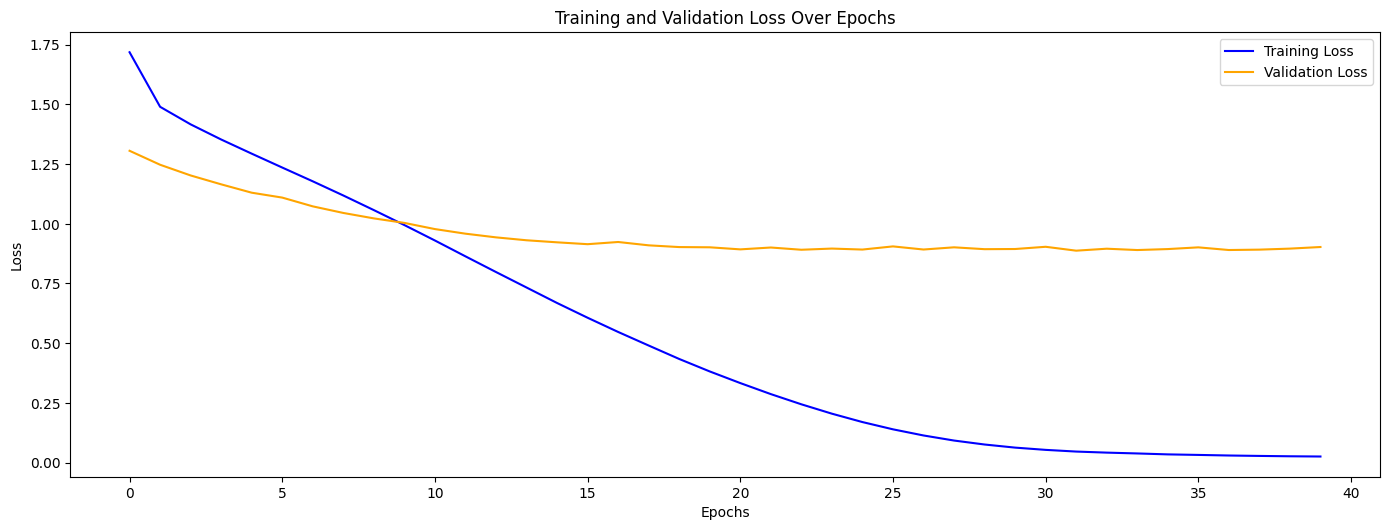

In [17]:
import matplotlib.pyplot as plt
# Plotting Loss and Accuracy
plt.figure(figsize=(14, 10))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [18]:
target_tokenizer.word_index

{'sos': 1,
 'eos': 2,
 'dan': 3,
 'yang': 4,
 'di': 5,
 'pada': 6,
 'dari': 7,
 'dengan': 8,
 'untuk': 9,
 'ini': 10,
 'dalam': 11,
 'tahun': 12,
 'adalah': 13,
 'sebagai': 14,
 'oleh': 15,
 'ia': 16,
 'ke': 17,
 'tidak': 18,
 'menjadi': 19,
 'juga': 20,
 'tersebut': 21,
 'mereka': 22,
 'sebuah': 23,
 'itu': 24,
 'atau': 25,
 'bahwa': 26,
 'setelah': 27,
 'orang': 28,
 'satu': 29,
 'tanggal': 30,
 'film': 31,
 'memiliki': 32,
 'lebih': 33,
 'karena': 34,
 'bahasa': 35,
 'telah': 36,
 'dia': 37,
 'beberapa': 38,
 'seorang': 39,
 'the': 40,
 'dapat': 41,
 'negara': 42,
 'kota': 43,
 'secara': 44,
 'akan': 45,
 'merupakan': 46,
 'pertama': 47,
 'kemudian': 48,
 'bagian': 49,
 'saat': 50,
 'para': 51,
 'seperti': 52,
 'besar': 53,
 'dua': 54,
 'amerika': 55,
 'inggris': 56,
 'namun': 57,
 '–': 58,
 '1': 59,
 'dunia': 60,
 'banyak': 61,
 'ada': 62,
 'selama': 63,
 'antara': 64,
 'lain': 65,
 'baru': 66,
 'salah': 67,
 'indonesia': 68,
 'hanya': 69,
 'of': 70,
 '2': 71,
 'nama': 72,
 'anak':

In [19]:
target_tokenizer.index_word

{1: 'sos',
 2: 'eos',
 3: 'dan',
 4: 'yang',
 5: 'di',
 6: 'pada',
 7: 'dari',
 8: 'dengan',
 9: 'untuk',
 10: 'ini',
 11: 'dalam',
 12: 'tahun',
 13: 'adalah',
 14: 'sebagai',
 15: 'oleh',
 16: 'ia',
 17: 'ke',
 18: 'tidak',
 19: 'menjadi',
 20: 'juga',
 21: 'tersebut',
 22: 'mereka',
 23: 'sebuah',
 24: 'itu',
 25: 'atau',
 26: 'bahwa',
 27: 'setelah',
 28: 'orang',
 29: 'satu',
 30: 'tanggal',
 31: 'film',
 32: 'memiliki',
 33: 'lebih',
 34: 'karena',
 35: 'bahasa',
 36: 'telah',
 37: 'dia',
 38: 'beberapa',
 39: 'seorang',
 40: 'the',
 41: 'dapat',
 42: 'negara',
 43: 'kota',
 44: 'secara',
 45: 'akan',
 46: 'merupakan',
 47: 'pertama',
 48: 'kemudian',
 49: 'bagian',
 50: 'saat',
 51: 'para',
 52: 'seperti',
 53: 'besar',
 54: 'dua',
 55: 'amerika',
 56: 'inggris',
 57: 'namun',
 58: '–',
 59: '1',
 60: 'dunia',
 61: 'banyak',
 62: 'ada',
 63: 'selama',
 64: 'antara',
 65: 'lain',
 66: 'baru',
 67: 'salah',
 68: 'indonesia',
 69: 'hanya',
 70: 'of',
 71: '2',
 72: 'nama',
 73: 'an

In [20]:
import torch
import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')

def calculate_bleu(model, dataloader, device, target_tokenizer, max_len=50):
    model.eval()
    bleu_scores = []
    
    with torch.no_grad():


        for key, (src, tgt) in enumerate(dataloader):

            src = src.to(device)
            tgt = tgt.to(device)

            # Prepare the target input (exclude the last token for decoder input)
            tgt_input = tgt[:, :-1]

            # Get model predictions
            outputs = model(src, tgt_input)
            predicted_tokens = torch.argmax(outputs, dim=-1)

            # Print the input, correct output, and predicted output for each sample
            for i in range(len(src)):
                # Decode the input sequence (src) into words (assuming it's for a translation task)
                input_words = [source_tokenizer.index_word.get(token.item(), '') for token in src[i] if token != 0]
                input_words = ' '.join(input_words)
                # Decode the correct output sequence (tgt) into words
                ref = [target_tokenizer.index_word.get(token.item(), '') for token in tgt[i] if token != 0]
                ref = ' '.join(ref)
                # Decode the predicted output sequence into words
                hyp = [target_tokenizer.index_word.get(token.item(), '') for token in predicted_tokens[i] if token != 0]
                hyp = ' '.join(hyp)

                # Calculate BLEU score
                bleu_score = sentence_bleu([ref], hyp)
                # Print the input, correct output, and predicted output
                print(f"Input: {input_words}")
                print(f"Correct Output (Target): {ref}")
                print(f"Predicted Output: {hyp}")
                print(f"Bleu Score: {bleu_score:.4f}")
                print('-' * 50)
                with open('predictions_transformer_test.csv', mode='a', newline='') as file:
                    if not os.path.exists('predictions_transformer_test.csv'):
                        writer.writerow(['Index', 'Input', 'Predicted Output', 'Correct Output', 'BLEU Score'])
                    writer = csv.writer(file)
                    writer.writerow([key + 1, input_words, hyp, ref, bleu_score])
                # Append to BLEU calculation
                bleu_scores.append(bleu_score)  # BLEU expects references as a list of lists

    # Calculate BLEU score using the references and hypotheses
    return np.mean(bleu_scores)

# Example usage:
bleu_score = calculate_bleu(model, test_dataloader, device, target_tokenizer)
print(f"Validation BLEU score: {bleu_score:.4f}")


[nltk_data] Downloading package punkt to /home/fachri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Input: byzantium could locally impose a rule over the balkan only on a short term basis not enough to them
Correct Output (Target): sos bizantium dapat secara lokal menerapkan aturan atas balkan hanya dalam jangka pendek tidak cukup untuk mereka eos
Predicted Output: keputusan dapat secara tidak secara baik atas hanya eos dalam jangka panjang mereka hanya untuk tidak eos
Bleu Score: 0.5687
--------------------------------------------------
Input: nasution escaped the attempt but in the event his daughter ade irma nasution and the first lieutenant pierre was murdered
Correct Output (Target): sos dalam peristiwa tersebut putri kedua dia ade irma nasution dan kapten anumerta pierre andreas gugur eos
Predicted Output: dalam peristiwa tersebut dia kedua putri dipanggil dia dan dan dia archer dan eos eos undp
Bleu Score: 0.5081
--------------------------------------------------
Input: there have also been moves at an international level most notably the council of europe european convention 

/home/fachri/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Input: in 1900 he graduated from the 28th class of the imperial japanese naval academy ranked second in his class of 105
Correct Output (Target): sos pada 1900 ia lulus dari kelas ke 28 angkatan laut kekaisaran jepang mendapatkan peringkat kedua di kelasnya dari 105 kadet eos
Predicted Output: pada 1871 ia lulus dari kelas ke 28 mei laut jepang jepang kedua kekaisaran kedua dari hiroshima dari bay eos ke
Bleu Score: 0.5698
--------------------------------------------------
Input: foreign investment helped to greatly increase quality knowledge and standards especially in heavy industry
Correct Output (Target): sos investasi asing turut membantu meningkatkan kualitas produk dan pengetahuan dan standar terutama di bidang industri berat eos
Predicted Output: keyakinan asing saja tiketnya bình kualitas dan terutama mendorong dan dijatuhi dan di bidang dan kimia eos
Bleu Score: 0.4288
--------------------------------------------------
Input: on march 1 the second platoon is ambushed from a j